In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from nltk.stem import WordNetLemmatizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
df_train['text'] = df_train['text'].apply(lambda x: x.lower())
df_test['text'] = df_test['text'].apply(lambda x: x.lower())

In [3]:
print(f'df_train.shape = {df_train.shape}')
print(f'df_test.shape = {df_test.shape}')

df_train['length'] = df_train['text'].apply(lambda x: len(x))
df_test['length']  = df_test['text'].apply(lambda x: len(x))
print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

df_train.shape = (7613, 5)
df_test.shape = (3263, 4)
Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [4]:
embedding_dim=100
path='/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'
max_len=np.max(df_train['length'])

In [5]:
def get_embeddings(path, embedding_dim):
    embedding_dim = embedding_dim  
    embedding_index = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embedding_index[word] = vector
    return embedding_index

In [6]:
def create_embedding_matrix(vocab_size, embedding_dim, embedding_index):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['text'])
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(df_train['text'])
X_train = pad_sequences(sequences, maxlen=max_len, padding='post')
y_train = df_train['target'].to_numpy()

test_sequences = tokenizer.texts_to_sequences(df_test['text'])
X_test = pad_sequences(test_sequences, maxlen=max_len, padding='post')
y_test = df_train['target'].to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=23)

print(f'X_train.shape = {X_train.shape}')
print(f'X_val.shape = {X_val.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'y_val.shape = {y_val.shape}')

X_train.shape = (6090, 157)
X_val.shape = (1523, 157)
y_train.shape = (6090,)
y_val.shape = (1523,)


In [8]:
embedding_index = get_embeddings(path=path, embedding_dim=embedding_dim)
embedding_matrix = create_embedding_matrix(vocab_size=vocab_size,
                                            embedding_dim=embedding_dim,
                                            embedding_index=embedding_index)

In [19]:
from tensorflow.keras.constraints import max_norm
def get_model(vocab_size, embedding_dim, max_len, embedding_matrix, units):
    input_layer = keras.layers.Input(shape=(max_len,))
    embedding_layer = keras.layers.Embedding(input_dim=vocab_size,
                                             output_dim=embedding_dim,
                                             input_length=max_len,
                                             weights=[embedding_matrix], 
                                             trainable=False)(input_layer)
    lstm1 = keras.layers.LSTM(units=units[0], kernel_initializer='glorot_uniform', kernel_constraint=max_norm(1),
                              dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embedding_layer)
    batch_norm1 = keras.layers.BatchNormalization()(lstm1)
    lstm2 = keras.layers.LSTM(units=units[1], kernel_initializer='glorot_uniform', kernel_constraint=max_norm(1),
                              dropout=0.2, recurrent_dropout=0.2, return_sequences=False)(lstm1)
    dropout = keras.layers.Dropout(0.2)(lstm2)
    output_layer = keras.layers.Dense(1, activation='sigmoid')(dropout)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [20]:
BATCH_SIZE=64
EPOCHS=50
LEARNING_RATE=1.e-5

In [21]:
def learning_rate_decay(epoch, lr):
    decay_rate = 0.5
    decay_step = 10  
    if epoch % decay_step == 0 and epoch:
        print(lr * decay_rate)
        return lr * decay_rate
    return lr

lr_decay_callback = keras.callbacks.LearningRateScheduler(learning_rate_decay)
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [22]:
opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
model = get_model(vocab_size=vocab_size,
                  embedding_dim=embedding_dim,
                  max_len=max_len,
                  embedding_matrix=embedding_matrix,
                  units=[1024,1024,1024])
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 157)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 157, 100)          2270100   
                                                                 
 lstm_6 (LSTM)               (None, 157, 1024)         4608000   
                                                                 
 lstm_7 (LSTM)               (None, 1024)              8392704   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 15,271,829
Trainable params: 13,001,729
Non-t

In [23]:
hist = model.fit(x=X_train,
                 y=y_train,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 validation_data=(X_val, y_val),
                 callbacks=[lr_decay_callback, early_stopping_callback])

Epoch 1/50
96/96 [==============================] - 149s 1s/step - loss: 0.6888 - accuracy: 0.5762 - val_loss: 0.6923 - val_accuracy: 0.5469 - lr: 1.0000e-05
Epoch 2/50
96/96 [==============================] - 148s 2s/step - loss: 0.6820 - accuracy: 0.5762 - val_loss: 0.6920 - val_accuracy: 0.5469 - lr: 1.0000e-05
Epoch 3/50
96/96 [==============================] - 146s 2s/step - loss: 0.6819 - accuracy: 0.5762 - val_loss: 0.6926 - val_accuracy: 0.5469 - lr: 1.0000e-05
Epoch 4/50
96/96 [==============================] - 146s 2s/step - loss: 0.6822 - accuracy: 0.5762 - val_loss: 0.6905 - val_accuracy: 0.5469 - lr: 1.0000e-05
Epoch 5/50
96/96 [==============================] - 146s 2s/step - loss: 0.6258 - accuracy: 0.6404 - val_loss: 0.5155 - val_accuracy: 0.7735 - lr: 1.0000e-05
Epoch 6/50
96/96 [==============================] - 146s 2s/step - loss: 0.4880 - accuracy: 0.7821 - val_loss: 0.4561 - val_accuracy: 0.8024 - lr: 1.0000e-05
Epoch 7/50
96/96 [==============================] - 

48/48 [==============================] - 9s 192ms/step - loss: 0.4132 - accuracy: 0.8122
Validation Loss = 0.4131747782230377 , Validation Accuracy = 81.22%


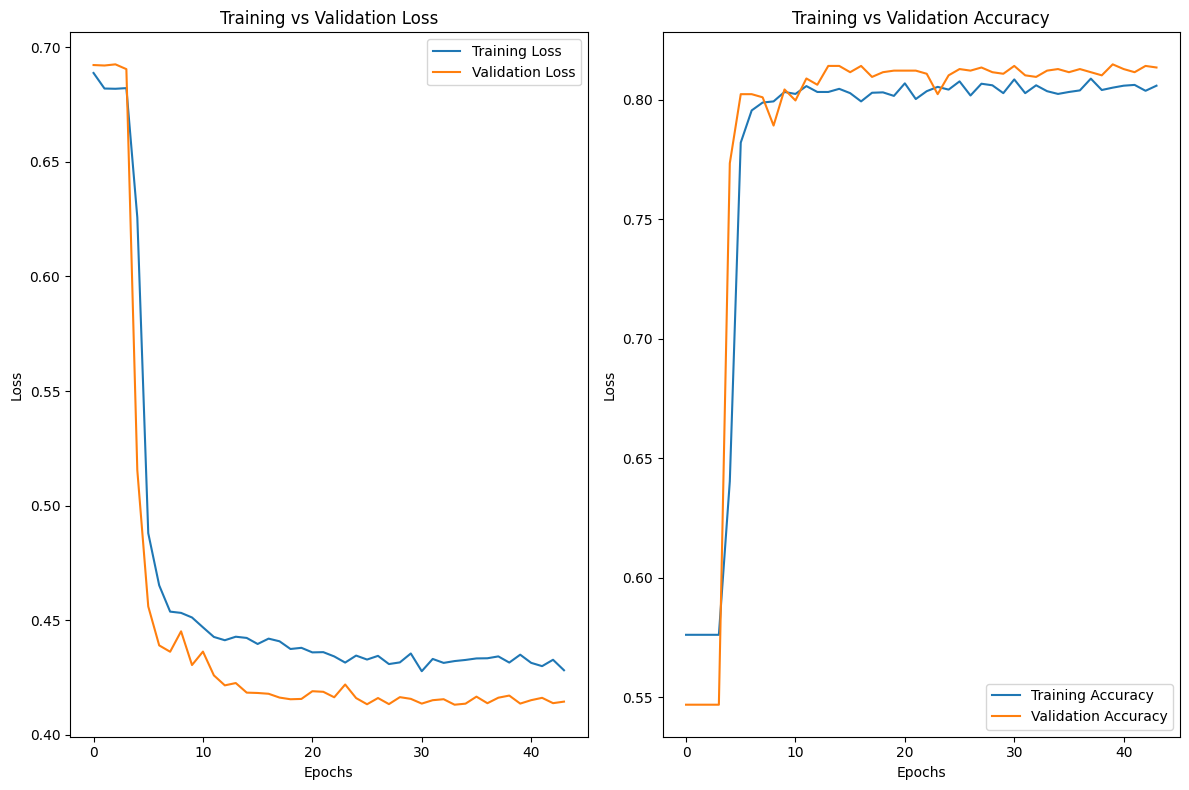

In [24]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss = {val_loss} , Validation Accuracy = {round(val_accuracy, 4)*100}%")
fig, axes = plt.subplots(1,2, figsize=(12,8))
axes = axes.flatten()
axes[0].plot(hist.history['loss'])
axes[0].plot(hist.history['val_loss'])
axes[0].set_title('Training vs Validation Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training Loss', 'Validation Loss'])

axes[1].plot(hist.history['accuracy'])
axes[1].plot(hist.history['val_accuracy'])
axes[1].set_title('Training vs Validation Accuracy')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training Accuracy', 'Validation Accuracy'])

plt.tight_layout()
plt.show()

